<a href="https://colab.research.google.com/github/jammy-bot/pneumonia-x-ray-deep-learning-classification/blob/master/pneumonia-x-ray-deep-learning-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia X-ray Deep Learning Classification

>For this project, we will be working with the __Chest X-Ray Images (Pneumonia)__ dataset, from Kaggle [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The objective of the project is to build a deep neural network model that can classify whether a given patient has pneumonia, given a chest x-ray image.

        Acknowledgements
        Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

        License: CC BY 4.0

        Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


# Notebook Preparation

Import required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers, models, initializers, optimizers
from keras.optimizers import SGD
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from keras import backend as K

import random
from random import shuffle
from tqdm import tqdm  

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Verify the current working directory



In [2]:
import os
!pwd

/content


Let's get a sense of our directory structure.

In [3]:
# using Ipython magic to move to the `root` folder
%cd /root/

# viewing root subdirectories as a list
# subdirs = [x[0] for x in os.walk('.')]
# print(subdirs)

# viewing root subdirectories in a vertical orientation
#for x in os.walk('.'):
#    print(x[0])

/root


Create a `data` subdirectory and a hidden `.kaggle` directory for data download credentials.

In [4]:
# creating a directory for sample data
!mkdir ./data/

# creating a directory for data download credentials
!mkdir ~/.kaggle

# list items in the `content` directory
!ls

data


Verify the hidden directory, and move into it.

In [5]:
%cd ~/.kaggle/

/root/.kaggle


Upload your **Kaggle API key** to the current, hidden directory.

In [6]:
# import neccessary library
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jameldargan","key":"c86fa0bb4d5a3b097d884a933f7f5b2e"}'}

Verify the current directory and its contents.

In [7]:
!pwd
%ls

/root/.kaggle
kaggle.json


__Update permissions__ on the json file to readable and writeabile by the owner and not readable, writeable, or executable by anyone else.

>  Clear output from the `files.upload()` cell, above, before saving publicly the notebook.

In [8]:
!chmod 600 ./kaggle.json

Move to the `content/data` directory.

In [9]:
%cd ..
%cd data/

# viewing the current, `data` directory
%ls

/root
/root/data


# Obtain Data

>The dataset is provided in "3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal)."

Download the dataset to the current `data`directory.

In [10]:
# downloading the dataset into `content/data'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:26<00:00, 51.4MB/s]
100% 2.29G/2.29G [00:27<00:00, 90.8MB/s]


Verify download.

In [11]:
%ls

chest-xray-pneumonia.zip


Inflate the compressed files.

In [12]:
# extracting the zipped files and directories
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

>We now have a `chest_xray` folder with subdirectories for *training*, *validation*, and *test* data.


In [13]:
# verify directory contents
!ls

chest_xray  chest-xray-pneumonia.zip



>Data added to Google Colab projects get cleared at the close of each session, so we do not need to worry about removing the `chest-xray-pneumonia.zip` compressed file.

In [14]:
# viewing 1 level deep
print(os.listdir("/root/data/chest_xray/chest_xray"))

['train', 'val', 'test', '.DS_Store']


In [15]:
# viewing next level
print(os.listdir("/root/data/chest_xray/chest_xray/val/"))

['NORMAL', 'PNEUMONIA', '.DS_Store']


# Scrub

In [16]:
# instantiate variables for dataset directory paths
train_dir = "/root/data/chest_xray/chest_xray/train/"
train_normal = train_dir + 'NORMAL'
train_pneumonia = train_dir + 'PNEUMONIA'

val_dir = "/root/data/chest_xray/chest_xray/val/"
val_normal = val_dir + 'NORMAL'
val_pneumonia = val_dir + 'PNEUMONIA'

test_dir = "/root/data/chest_xray/chest_xray/test/"
test_normal = test_dir + 'NORMAL'
test_pneumonia = test_dir + 'PNEUMONIA'

In [17]:
# instantiate variables for set lengths
tn_normal_length = len([f for f in os.listdir(
    train_normal) if f.endswith('.jpeg')])
tn_pneumonial_length = len([f for f in os.listdir(
    train_pneumonia) if f.endswith('.jpeg')])
val_normal_length = len([f for f in os.listdir(
    val_normal) if f.endswith('.jpeg')])
val_pneumonia_length = len([f for f in os.listdir(
    val_pneumonia) if f.endswith('.jpeg')])
tt_normal_length = len([f for f in os.listdir(
    test_normal) if f.endswith('.jpeg')])
tt_pneumonia_length = len([f for f in os.listdir(
    test_pneumonia) if f.endswith('.jpeg')])

# printing how many images we have in each directory
print('There are', tn_normal_length, 
'normal images in the training set\n')

print('There are', tn_pneumonial_length, 
'pneumonia images in the training set\n')

print('There are', val_normal_length, 
'normal images in the validation set\n')

print('There are', val_pneumonia_length, 
'pneumonia images in the validation set\n')

print('There are', tt_normal_length, 
'normal images in the test set\n')

print('There are', tt_pneumonia_length, 
'pneumonia images in the test set\n')

There are 1341 normal images in the training set

There are 3875 pneumonia images in the training set

There are 8 normal images in the validation set

There are 8 pneumonia images in the validation set

There are 234 normal images in the test set

There are 390 pneumonia images in the test set



>* Pneumonia images surpass the number of normal images nearly 3-fold, in the training data set.
* Altogether, there are more than 5000 training images, 16 validation images, and 624 test images.

# Explore and Model

In [18]:
# importing necessary libraries.
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

__Data Counts and Shapes__

__Standardize__ image data by dividing each matrix of rgb values by 255.

In [19]:
# instantiating rescaling generators tor train and val data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

__Reshape__ image data and labels

In [20]:
# generating training and validation data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir, 
        shuffle=True, 
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


__Visualize Training Data Counts__

In [21]:
def bar_plot(dir):
    x_dir = os.listdir(dir+'/NORMAL')
    y_dir = os.listdir(dir+'/PNEUMONIA')
    x=len(x_dir)
    y=len(y_dir)
    if dir != test_dir: 
        # account for non - image files in `train` and `val` directories
        x = x - 1
        y = y - 1
    print(f'{dir} Images:\n')
    print('NORMAL:', x)
    print('PNEUMONIA:', y)
    print('Total images:', x + y)
    print('-'*50)
    # instantiate directory name for plot title
    subdir_title = str.split(dir, '/')[-2] + ' directory'
    category = ['NORMAL', 'PNEUMONIA']
    count = [x, y]
    plot = plt.bar(category,count) 
    plot[0].set_color('orange')
    plt.title(
        f"Number of values per category in {subdir_title.title()}\n")
    plt.show()

/root/data/chest_xray/chest_xray/train/ Images:

NORMAL: 1341
PNEUMONIA: 3875
Total images: 5216
--------------------------------------------------


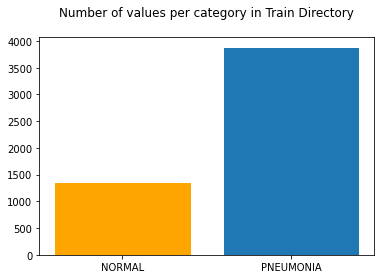

In [22]:
# plotting training data counts
bar_plot(train_dir)

> Training data is noticeably unbalanced.

/root/data/chest_xray/chest_xray/val/ Images:

NORMAL: 8
PNEUMONIA: 8
Total images: 16
--------------------------------------------------


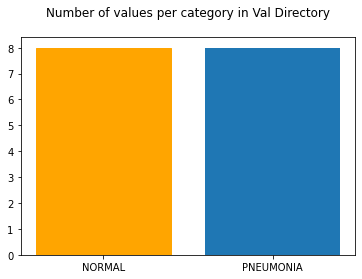

In [23]:
# plotting validation data counts
bar_plot(val_dir)

/root/data/chest_xray/chest_xray/test/ Images:

NORMAL: 234
PNEUMONIA: 390
Total images: 624
--------------------------------------------------


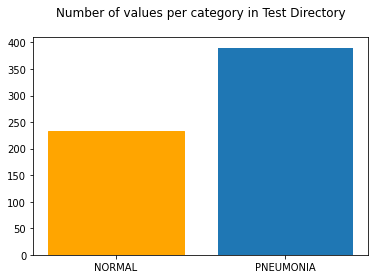

In [24]:
# plotting test data counts
bar_plot(test_dir)

> Test data is unbalanced, in the same direction as training data, though not as severely.

### Preview Images

In [25]:
# instantiate variables for a training image from each class
normal_example = os.listdir(f'{train_dir}/NORMAL')[33]
pneumonia_example = os.listdir(f'{train_dir}/PNEUMONIA')[33]

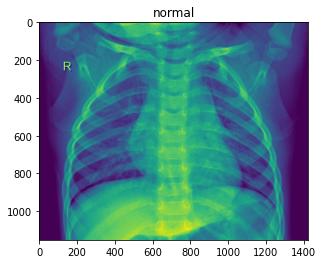

In [26]:
# plot a normal class training image
normal_img = plt.imread(f'{train_dir}/NORMAL/{normal_example}')
plt.title("normal")
plt.imshow(normal_img)
plt.show()

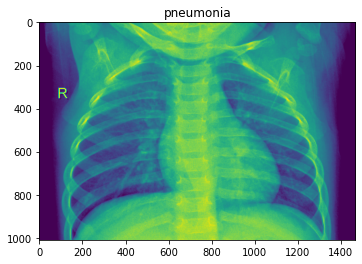

In [27]:
# plot a pneumonia class training image
pneumonia_img = plt.imread(f'{train_dir}/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)
plt.title('pneumonia')
plt.show()

## Design Model 1
>Using Keras:
* Design a simple convolutional neural network (cnn)
* We will 'flatten' to a send a single dimension array to the single - node output layer 
* Compile this model

In [28]:
# importing necessary libraries
# from keras import layers
# from keras import models
# from keras import optimizers

In [29]:
# building the CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
# compiling the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [31]:
# importing keras modules
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import ReduceLROnPlateau

In [32]:
# creating a directory for saving models
!mkdir ./models/

Create Checkpoints in the Model History

>Import keras modules: 
* to stop training when a monitored quantity has stopped improving
* to save the model after every epoch
* to reduce learning rate when a metric has stopped improving


In [33]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    # stopping if no improvement after 15 epochs
    EarlyStopping(patience=15, verbose=1),
    ## reducing learning rate if no improvement after 3 epochs
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1),
    # saving the full model at each improvement
    ModelCheckpoint(filepath = f_path + 'p3_model.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [34]:
# training and evaluating the model
# using the callback in the `model.fit`
history = model.fit_generator(train_generator,  
                              # 64 steps for each of 82 epochs, for
                              # up to 5248 training samples
                              steps_per_epoch=64, 
                              epochs=82, 
                              validation_data=validation_generator, 
                              validation_steps=16, 
                              class_weight = 'auto',
                              callbacks = my_callbacks)

Epoch 1/82
64/64 [==============================] - 27s 423ms/step - loss: 0.5100 - acc: 0.7935 - val_loss: 0.6424 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.64244, saving model to ./models/p3_model.h5
Epoch 2/82
64/64 [==============================] - 21s 330ms/step - loss: 0.2806 - acc: 0.8794 - val_loss: 0.4131 - val_acc: 0.8125

Epoch 00002: val_loss improved from 0.64244 to 0.41310, saving model to ./models/p3_model.h5
Epoch 3/82
64/64 [==============================] - 22s 341ms/step - loss: 0.1741 - acc: 0.9385 - val_loss: 0.5450 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.41310
Epoch 4/82
64/64 [==============================] - 21s 334ms/step - loss: 0.1465 - acc: 0.9487 - val_loss: 0.2925 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.41310 to 0.29249, saving model to ./models/p3_model.h5
Epoch 5/82
64/64 [==============================] - 22s 337ms/step - loss: 0.1256 - acc: 0.9570 - val_loss: 0.2921 - val_acc: 0.8750

Epoc

In [35]:
val_loss, val_acc = model.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.750544011592865
val acc: 0.875


> Note:
* The reported validation scores are based on the model's last epoch weignts, not on its best.
* At the 28th epoch, the model achieves a validation accuracy of 100 \%. This may be a sign that the model is over - fitting.

__Visualize Training Results__

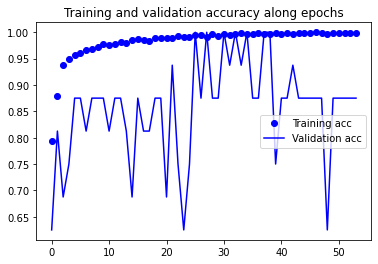

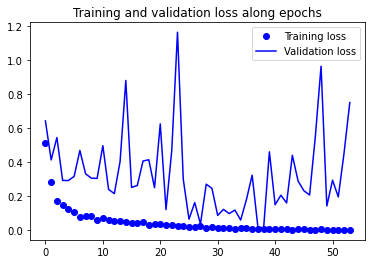

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

> The jagged validation loss and accuracy suggest that our model has room for improvement. Options can include making adjustments to any on or several parameters, including verifying __shuffling__ of the training data, increasing the batch size or steps per batch to ensure reasonable sampling from each class during training, __longer training time__ (more epochs).
* In addition, accuracy begins to drop noticeably--and loss to increase--at about 37 epochs.

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [52]:
# download the model locally
files.download('./models/p3_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This can take quite a long time to run. It might be better to test loading weights, only, when modeling for production. 



> We'll reload the saved model.
* The best model was saved via callbacks to 'p3_model.h5'.
* We can evaluate it against our validation generator, to verify that the score reported above was based on our best model weights.



In [38]:
from keras.models import load_model
 
# loading model
model = load_model('./models/p3_model.h5')

# viewing a textual representation of the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 331776)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                21233728  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,253,185
Trainable params: 21,253,185
Non-trainable params: 0
__________________________________________

Run the saved model on validation data to see if we approximate the validation scores reported above.

In [39]:
val_loss, val_acc = model.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.013654939830303192
val acc: 1.0


* Loss and accuracy scores are each higher, for the test set.
* We can evaluate the model on test data.

In [40]:
# running the test set in one batch
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=624, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=16)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 1.3115425109863281
test acc: 0.7948718070983887


> We see the following results from applying our model to the test set.
>
>|val loss: 0.045||test loss: 0.98|
>|----|----|----|
>|val acc: 1.0||test acc: 0.80|

>
>
* Compared to results from the validation set, loss is 53 points higher.
* Accuracy is 20 points lower, on the test set.

Let's check a __classification report__.

In [41]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model.predict_generator(test_generator)
y_pred = np.rint(y_pred)

In [42]:
# from sklearn.metrics import confusion_matrix, classification_report
# viewing classification report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.36      0.18      0.24       234
           1       0.62      0.80      0.70       390

    accuracy                           0.57       624
   macro avg       0.49      0.49      0.47       624
weighted avg       0.52      0.57      0.53       624



> We see a good recall score for pneumonia images, which is a useful indicator.
* Recall indicates the ratio of positive predictions to the total number of actual positive samples, calculated as TP/(TP + FN).
* We can gain additional clarity from visualizing a confusion matrix plot for our model results.

[[ 43 191]
 [ 77 313]]


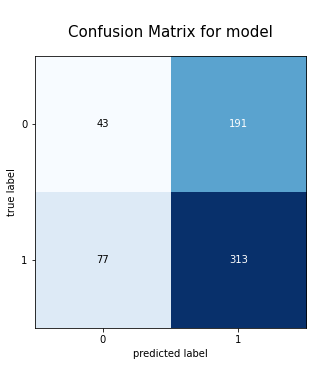

In [43]:
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM, 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for model", 
          fontsize=15)
fig.savefig("model_1_CM", dpi=100)
plt.show()

In [44]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  120
Predicted 'PNEUMONIA': 504


> `See analysis, below.`

In [45]:
# categorizing results
def perf_measure(y_true, y_pred):
    """
    Takes 'actual' and 'predicted' labels and returns the number of
    true negative, true positive, false negative, and false positive
    predictions
    """
    TN = CM[0][0]
    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]

#    print(f"TN = {TN}\nTP = {TP}\nFN = {FN}\nFP = {FP}\n")

    return None

In [46]:
#viewing performance measures
perf_measure(y_true, y_pred)

This report encouraging, though not ideal:
>* __T__rue __N__egatives (pred 0, true 0): the number of patients correctly predicted to not to have pneumonia: 45
* __T__rue __P__ositives (pred 1, true 1): the number of patients correctly predicted to have pneumonia: 312
* __F__alse __N__egatives (pred 0, true 1): the number of patients falsely predicted to not to have pneumonia: __78__
* __F__alse __P__ositives (pred 1, true 0): the number of patients falsely predicted to have pneumonia: __189__

False positives would be preferred over false negatives, in this type of case.
>* Where false positives could unnecessarily result in additional testing, false negatives could result in failure to treat patients that require treatment.
* Our false positive results far outweigh false negative results
* Now, our target is a model that achieves lower error, overall.

### * Tuning Hyperperameters


__Data Generation__
> There are a number of approaches we can take to make our data more 'generalizeable', so that we optimize its ability to perfom well with new, unseen data.

Let's run a few things up the flagpole.

In [47]:
# instantiating a datagen to slightly transform images within
# specified ranges
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.15, 
                                   height_shift_range=0.2, 
                                   shear_range=0.15, 
                                   zoom_range=0.2, 
                                   horizontal_flip=False, #
                                   fill_mode='nearest')

# generating transformed training data on - the - fly
# transformations may slow the fit process
train_generator = train_datagen.flow_from_directory(
        # using the same hyperparameters as the first model
        train_dir, 
        shuffle=True, 
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=652,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# we don't need to make adjustments to the final test set, but we can
# use a datagen to scale validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# transforming only image size, for validation data
validation_generator = test_datagen.flow_from_directory(val_dir, 
                                    target_size=(150, 150), 
                                    batch_size=8,  # half the sample
                                    class_mode='binary')



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Augmented `model_b`

In [48]:
## # build on the first model to create `model_b`
input_shape = (150, 150, 3)
print(input_shape)

model_b = models.Sequential()
model_b.add(layers.Conv2D(32, (2, 2), activation='relu', 
                        input_shape=input_shape))
model_b.add(layers.MaxPooling2D((2, 2)))

model_b.add(layers.Conv2D(64, (3, 3), activation='relu'))
# adding a pooling layer
model_b.add(layers.MaxPooling2D((2, 2)))

# increasing model depth
model_b.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_b.add(layers.MaxPooling2D((2, 2)))

model_b.add(layers.Flatten())
model_b.add(layers.Dense(64, activation='relu'))
model_b.add(layers.Dense(1, activation='sigmoid'))

(150, 150, 3)


Compile `model_b`

In [49]:
# compiling the model
model_b.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

# adding callback functions
f_path = './models/'

my_callbacks = [
    # stopping if no improvement after 20 epochs (+ 5)
    EarlyStopping(patience=20, verbose=1),
    ## reducing learning rate if no improvement after 3 epochs
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # saving the full model at each improvement
    ModelCheckpoint(filepath = f_path + 'p3_model_a.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]


Fit `model_b`

In [53]:
# fitting a model to training set including transformations
history_b = model_b.fit_generator(train_generator,  
                              # 16 steps for each of 326 epochs, for
                              # 5216 training samples
                              steps_per_epoch=16,   # down from 32
                              epochs=326,           # up from 163
                              validation_data=validation_generator, 
                              validation_steps=16, 
                              class_weight = 'auto',
                              callbacks = my_callbacks)

Epoch 1/326
16/16 [==============================] - 157s 10s/step - loss: 0.3080 - acc: 0.8707 - val_loss: 0.6941 - val_acc: 0.5000

Epoch 00001: val_loss did not improve from 0.68859
Epoch 2/326
16/16 [==============================] - 151s 9s/step - loss: 0.2647 - acc: 0.8916 - val_loss: 0.6849 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.68859 to 0.68485, saving model to ./models/p3_model_a.h5
Epoch 3/326
16/16 [==============================] - 151s 9s/step - loss: 0.2563 - acc: 0.8933 - val_loss: 0.6829 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.68485 to 0.68288, saving model to ./models/p3_model_a.h5
Epoch 4/326
16/16 [==============================] - 150s 9s/step - loss: 0.2312 - acc: 0.9084 - val_loss: 0.7038 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.68288
Epoch 5/326
16/16 [==============================] - 150s 9s/step - loss: 0.2955 - acc: 0.8776 - val_loss: 0.6980 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from

In [54]:
val_loss, val_acc = model_b.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.7077474594116211
val acc: 0.5


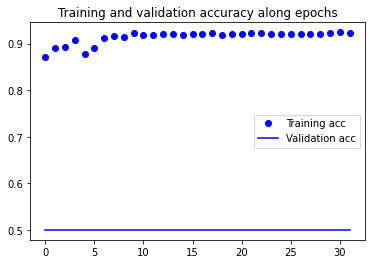

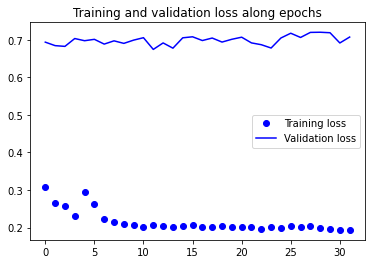

In [55]:
acc = history_b.history['acc']
val_acc = history_b.history['val_acc']
loss = history_b.history['loss']
val_loss = history_b.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

### Evaluate model_b on Test Data

In [56]:
# using 39 batches of 16 steps for 624 test samples
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=39, 
                                                  class_mode='binary')

# using 39 steps to increase samples per batch
test_loss, test_acc = model_b.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.6758642792701721
test acc: 0.6219592094421387


> After viewing validation scores for the augmented model, I did not neccessarily expect to see improvement in test scores over our first model. But, here we are:
>
>|model test loss: 0.98||model_b test loss: 0.68|
>|----|----|----|
>|model test acc: 0.80||test acc: 0.84|

> `model_b` hit a plateau for accuracy at epoch 5 and validation loss did not improve after epoch 16.
* Conventional wisdom prepared me to accept that there is not a lot, if any, benefit to changing numerous hyperperameters all at once. The approach is likely to not work, training can be much more expensive, and any change in results are difficult to interpret.
* About half of our training time was wasted time
* Without performing a resource - heavy gridsearch, it may be best to adjust only one or two things to determine how the adjustments benefit or harm model performance.

Instead, we have achieved improvements in both loss and accuracy.
> It may still be valuable to return to the original model and try:
* changing only datagen transformations,
* making adjustments to the optimizer used

First, let's see how our performance measures have been affected.

In [57]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model_b.predict_generator(test_generator)
y_pred = np.rint(y_pred)

[[  0 234]
 [  0 390]]


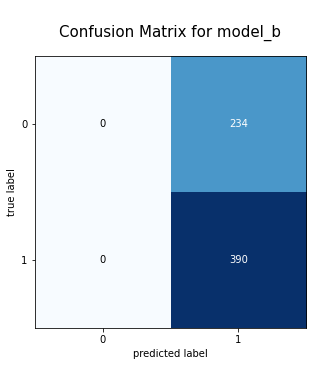

In [58]:
# plotting confusion matrix
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM, 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for model_b", 
          fontsize=15)
fig.savefig("model_1_CM", dpi=100)
plt.show()

In [59]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  0
Predicted 'PNEUMONIA': 624


> `See analysis, below.`

In [60]:
#viewing performance measures
perf_measure(y_true, y_pred)

`model_b` actually has __more__ false negatives than the first model. In that regard, it is not an improvement. Ideally, we would see improvement in our recall score Recall = TP/(TP + FN)

## `model_c`


__Change One Thing__, only.

> So, let's go ahead and add only the transformations to the first model.

In [61]:
# instantiating a datagen to slightly transform images within
# specified ranges (including the original rescaling)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.15, 
                                   height_shift_range=0.2, 
                                   shear_range=0.15, 
                                   zoom_range=0.2, 
                                   horizontal_flip=False, #
                                   fill_mode='nearest')

# re - instantiating our original training and validation generators
# to include the new datagen transformations
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir, 
        shuffle=True, 
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)  # original rescaling

validation_generator = test_datagen.flow_from_directory(val_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [62]:
# building the transformed training data `model_c`
input_shape = (150, 150, 3)

# using the original model architecture
model_c = models.Sequential()

model_c.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape))
model_c.add(layers.MaxPooling2D((2, 2)))

model_c.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_c.add(layers.Flatten())
model_c.add(layers.Dense(64, activation='relu'))
model_c.add(layers.Dense(1, activation='sigmoid'))

In [63]:
# compiling the model
model_c.compile(loss='binary_crossentropy', 
                # we can increase the learning rate and let it reduce
                # via the ReduceLROnPlateau callback function
              optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=['acc'])

In [64]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    # stopping if no improvement after 15 epochs
    EarlyStopping(patience=15, verbose=1),
    # reducing learning rate if no improvement after 3 epochs
    # correcting the min_lr, to ensure it is lower than the start
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # saving the full model at each improvement
    ModelCheckpoint(filepath = f_path + 'p3_model_c.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [65]:
# training and evaluating the model with transformations
history_c = model_c.fit_generator(train_generator,  
                              # 32 steps for each of 163 epochs, for
                              # 5216 training samples
                              steps_per_epoch=32, 
                              epochs=163, 
                              validation_data=validation_generator, 
                              validation_steps=16, 
                              class_weight = 'auto',
                              callbacks = my_callbacks)

Epoch 1/163
32/32 [==============================] - 18s 550ms/step - loss: 3.9728 - acc: 0.6826 - val_loss: 0.7266 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.72658, saving model to ./models/p3_model_c.h5
Epoch 2/163
32/32 [==============================] - 15s 469ms/step - loss: 0.6366 - acc: 0.7295 - val_loss: 1.1406 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.72658
Epoch 3/163
32/32 [==============================] - 16s 492ms/step - loss: 0.8412 - acc: 0.6836 - val_loss: 0.5823 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.72658 to 0.58234, saving model to ./models/p3_model_c.h5
Epoch 4/163
32/32 [==============================] - 15s 463ms/step - loss: 0.5904 - acc: 0.7373 - val_loss: 0.5708 - val_acc: 0.6875

Epoch 00004: val_loss improved from 0.58234 to 0.57081, saving model to ./models/p3_model_c.h5
Epoch 5/163
32/32 [==============================] - 15s 455ms/step - loss: 0.4782 - acc: 0.7725 - val_loss: 1.0296 - val_acc: 0

> That was a much quicker model. How did it perform?

In [66]:
# downloading the model locally
files.download('./models/p3_model_c.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



> We'll reload the saved model.
* The best model was saved via callbacks to 'p3_model.h5'.
* We can evaluate it against our validation generator, to verify that the score reported above was based on our best model weights.



In [67]:
# reloading saved model and best weights
from keras.models import load_model
 
# loading model
model = load_model('./models/p3_model_c.h5')

# viewing model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 331776)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                21233728  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 21,253,185
Trainable params: 21,253,185
Non-trainable params: 0
__________________________________________

In [68]:
val_loss, val_acc = model_c.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.7509524822235107
val acc: 0.75


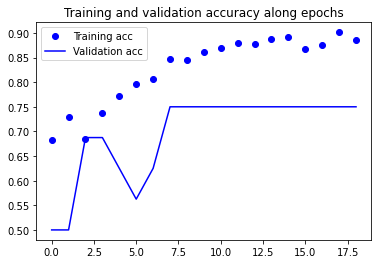

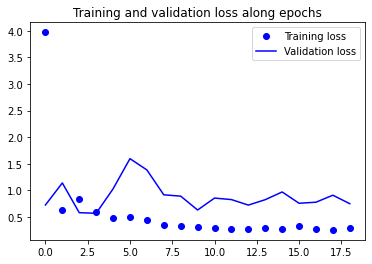

In [69]:
acc = history_c.history['acc']
val_acc = history_c.history['val_acc']
loss = history_c.history['loss']
val_loss = history_c.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

While there appears to be a general tendency, between training data and predictions for validation data, the validation batch size (only 16 total samples) may prevent the convergence we would like to see in our validation accuracy and loss plots.

### Evaluate model_c on Test Data

In [70]:
# using 39 batches of 16 steps for 624 test samples
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=39, 
                                                  class_mode='binary')

# using 39 steps to increase samples per batch
test_loss, test_acc = model_c.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.347364217042923
test acc: 0.8185404539108276


> We can compare our latest results to `model_b`, even though we consider that model to have unfavorable type - error ratios:
>
>|model_b test loss: 0.68||model_c test loss: 0.47|
>|----|----|----|
>|model_b test acc: 0.84||model_c test acc: 0.81|

> Again, we have achieved improvements in both loss and accuracy.
* Let's check performance measures.

In [71]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model_c.predict_generator(test_generator)
y_pred = np.rint(y_pred)

[[ 79 155]
 [136 254]]


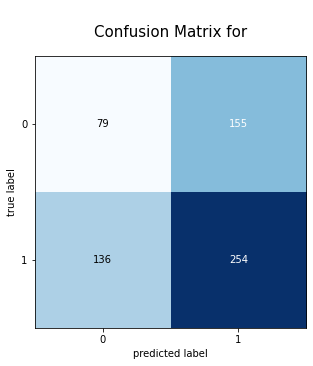

In [72]:
# plotting confusion matrix
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM, 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for", 
          fontsize=15)
fig.savefig("model_1_CM", dpi=100)
plt.show()

These metrics appear to not be too far off from `model_b`

In [73]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  215
Predicted 'PNEUMONIA': 409


In [74]:
#viewing performance measures
perf_measure(y_true, y_pred)

`model_b` actually has __more__ false negatives than the first model. In that regard, it is not an improvement. Ideally, we would see improvement in our recall score Recall = TP/(TP + FN)

# Select a Final Model (example)

> We have more work to do with this set, but le's see what it would look like to work with a completed model.
* We will look at a model applied to the same dataset.
* This model uses an RMSprop optimizer.

In [75]:
# evaluating the best model on test data
# setting steps to 39 and batch_size to 16 (for 624 images)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=16, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.8727091550827026
test acc: 0.6730769276618958


* This model also may be used as a basis for further tuning or distributed as - is.

## Distribution

* Since we previously saved our `my_model.h5` model, we can distribute it and use it on another system or for another project.
* A string summary of the mode's architecture may be saved and shared, as well.

In [76]:
# loading the saved model
from keras.models import load_model

filepath = '/root/data/models/p3_model.h5' # current path to saved file

dist_model = load_model(filepath, 
         custom_objects={'loss':'binary_crossentropy'})

# printing string summary
dist_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 331776)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                21233728  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,253,185
Trainable params: 21,253,185
Non-trainable params: 0
__________________________________________

In addition, t model's architecture may be shared as an image.

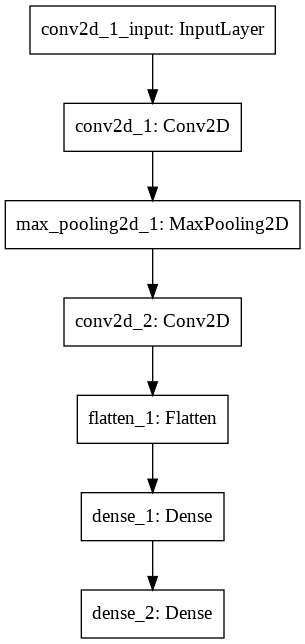

In [77]:
from keras.utils import plot_model

# plot model architecture, only
plot_model(dist_model)

# Summary / Future Work
We created a few supervised learning models, to look at how we might predict whether or not a patient has pneumonia, based on x-ray images of patient lungs.
> This project takes into consideration the particular requirements of performing data science modeling for a non - trivial task.
* A model with too many incorrect predictions (errors) could result in failure to properly diagnose and treat patient illness.
* Given prediction errors, it would be preferable to predict more false positives than false negatives--incorrectly identifying disease, which may lead to additional tests, rather than incorrectly determining that there is no disease, which may lead to a lack of necessary treatment.

A tool that may be useful for additional work on this project is the precision-recall curve.
![image.png](https://github.com/jammy-bot/pneumonia-x-ray-deep-learning-classification/blob/master/images/pre-rec-example-1.png | via https://acutecaretesting.org/)*Example of precision-recal curve plot*
The precision-recall plot provides at - a - glance visualization of model performance, particularly relevant to this type of problem, where you first and foremost want to ensure that the model identifies the vast majority of persons with the disease as having the disease. Usefully, this plot is less sensitive to training imbalance than an ROC.

To further tune our model, we can make adjustments to the many available hyperparameters:
* differnt transformations in __data augmentation__
* increase, decrease, or __alter layers__ and __model depth__
* use different __activations__
* add __dropout__ layers that only pass - on _some_ of the data to the next layer, to help prevent overfitting....
* Of course, there is also the gold standard: __more data__

